## Data load and cleanup

In [15]:
!pip install -r requirements.txt

    100% |████████████████████████████████| 24.2MB 2.0MB/s eta 0:00:01    49% |████████████████                | 12.1MB 69.0MB/s eta 0:00:01
    100% |████████████████████████████████| 1.6MB 25.5MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 31.4MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 31.5MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 30.2MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 35.9MB/s a 0:00:01
    100% |████████████████████████████████| 983kB 26.5MB/s ta 0:00:01
    100% |████████████████████████████████| 28.7MB 1.7MB/s eta 0:00:01    95% |██████████████████████████████▌ | 27.3MB 67.9MB/s eta 0:00:01
    100% |████████████████████████████████| 143kB 36.0MB/s ta 0:00:01
    100% |████████████████████████████████| 225kB 37.8MB/s ta 0:00:01
    100% |████████████████████████████████| 655kB 30.6MB/s ta 0:00:01
    100% |████████████████████████████████| 368kB 33.2MB/s ta 0:00:01
    100% |████████████

    100% |████████████████████████████████| 133kB 35.1MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 36.3MB/s a 0:00:01
    100% |████████████████████████████████| 81kB 15.8MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 34.8MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 40.2MB/s ta 0:00:01
    100% |████████████████████████████████| 1.0MB 26.0MB/s ta 0:00:01


  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ab/10/93/5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
  Running setup.py bdist_wheel for gin-config ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ce/c8/46/5e7bf52dc31cb4fe1b541c27463b970150b2d8651105784a32
  Running setup.py bdist_wheel for google-api-python-client ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b8/f6/f5/b7bef1a5bc0e07ca4aa54c596b0b574c5afc07a9fddccf08f8
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
  Running setup.py bdist_wheel for pypng ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
  Running setup.py bdist_wheel for dopamine-rl ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/75/01/fa/43ebcfe0f37d8c27bb

In [2]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

In [3]:
import json
import os
import pandas as pd
import numpy as np
from itertools import combinations

from utils import get_raw_data, data_download

data_path = get_raw_data()

File already downloaded.


In [10]:
entity_type = "movie"

In [12]:
def load_training_dataset(entity_type):
  with open(os.path.join(data_path, 'train.json'), 'r') as f:
    train_df = pd.read_json(f)
    
    train_df = train_df[train_df.entity_type==entity_type]
    train_df.drop(columns=['entity_type', 'episode_number', 'problem_space', 'season_number', 'series_description', 'series_entity_id', 'series_name', 'series_premiere'], inplace=True)
    train_df.drop(columns=['ver_id', 'id', 'source_id'], inplace=True)
  
  return train_df


train_df = load_training_dataset(entity_type)
train_df.head()

,description,entity_id,genres,name,premiere
0,Fox is an edge-of-the-seat suspense thriller t...,fb12ea15f0a94392998e6ba8f0828593,"Drama,International,Mystery",Fox,2009-09-04T00:00:00.000Z
3,"In Washington, D.C., in the year 2054, murder ...",ed090fa63254441ab3d4dd83c9ddc891,"Action,Adventure,Science Fiction",Minority Report,2002-06-21T00:00:00.000Z
4,Andrew McMahon has a momentous year: He releas...,b2725ec69dc54f5e9a687c84487cf30a,Documentaries,Dear Jack,2009-01-01T00:00:00.000Z
6,From The Producer of THE STRANGERS and the wri...,93c2491ae356408d8d04a63907b42fee,"Horror,Supernatural",At The Devil's Door,2014-08-08T00:00:00.000Z
10,Filmmaker Tommy Davis follows four Mexican mig...,fecd9360da1d4370b91481eec4621d18,Documentaries,Mojados: Through the Night,2004-03-12T00:00:00.000Z


## genres

In [13]:
genre_dict = {'next': 1}


def genre_array_to_dict(row):
  genre_mapping = []
  for g in row:
    next_genre = genre_dict['next']
    g_num = genre_dict.setdefault(g, next_genre)
    if g_num == next_genre:
      genre_dict['next'] += 1
    genre_mapping.append(g_num)
  return genre_mapping
  
genres_df = train_df.genres.str.split(',').apply(lambda x: genre_array_to_dict(x))
genres_df.head()


0     [1, 2, 3]
3     [4, 5, 6]
4           [7]
6        [8, 9]
10          [7]
Name: genres, dtype: object

## descriptions

In [16]:
from gensim.parsing.preprocessing import preprocess_string, strip_multiple_whitespaces, strip_non_alphanum, strip_punctuation, remove_stopwords
CUSTOM_FILTERS = [lambda x: x.lower(), strip_multiple_whitespaces, strip_non_alphanum, strip_punctuation, remove_stopwords]

def preprocess(row):
  if not row:
    return ''
  return ' '.join(preprocess_string(row, CUSTOM_FILTERS))

description_string_df = train_df.description.apply(lambda x: preprocess(x))
description_string_df.head()


0     fox edge seat suspense thriller moves high spe...
3            washington d c year 2054 murder eliminated
4     andrew mcmahon momentous year releases album b...
6     producer strangers writer director pact comes ...
10    filmmaker tommy davis follows mexican migrants...
Name: description, dtype: object

In [18]:
from tensor2tensor.data_generators import text_encoder

description_df = description_string_df.apply(lambda x: text_encoder.ByteTextEncoder().encode(x))
description_df.head()

0     [104, 113, 122, 34, 103, 102, 105, 103, 34, 11...
3     [121, 99, 117, 106, 107, 112, 105, 118, 113, 1...
4     [99, 112, 102, 116, 103, 121, 34, 111, 101, 11...
6     [114, 116, 113, 102, 119, 101, 103, 116, 34, 1...
10    [104, 107, 110, 111, 111, 99, 109, 103, 116, 3...
Name: description, dtype: object

## titles

In [19]:
name_df = train_df.name.apply(lambda x: text_encoder.ByteTextEncoder().encode(x))
name_df.head()

0                                        [72, 113, 122]
3     [79, 107, 112, 113, 116, 107, 118, 123, 34, 84...
4              [70, 103, 99, 116, 34, 76, 99, 101, 109]
6     [67, 118, 34, 86, 106, 103, 34, 70, 103, 120, ...
10    [79, 113, 108, 99, 102, 113, 117, 60, 34, 86, ...
Name: name, dtype: object

## dates

In [20]:
dates = pd.to_datetime(train_df.premiere)
year_df = dates.dt.year.rename('year')
month_df = dates.dt.month.rename('month')
day_df = dates.dt.day.rename('day')
dates_df = pd.concat([year_df, month_df, day_df], axis=1)
dates_df.head()

,year,month,day
0,2009,9,4
3,2002,6,21
4,2009,1,1
6,2014,8,8
10,2004,3,12


## preprocessed data

In [21]:
data_df = pd.concat([train_df.entity_id, name_df, description_df, genres_df, year_df, month_df, day_df], axis=1).reset_index(drop=True)
data_df.head()

,entity_id,name,description,genres,year,month,day
0,fb12ea15f0a94392998e6ba8f0828593,"[72, 113, 122]","[104, 113, 122, 34, 103, 102, 105, 103, 34, 11...","[1, 2, 3]",2009,9,4
1,ed090fa63254441ab3d4dd83c9ddc891,"[79, 107, 112, 113, 116, 107, 118, 123, 34, 84...","[121, 99, 117, 106, 107, 112, 105, 118, 113, 1...","[4, 5, 6]",2002,6,21
2,b2725ec69dc54f5e9a687c84487cf30a,"[70, 103, 99, 116, 34, 76, 99, 101, 109]","[99, 112, 102, 116, 103, 121, 34, 111, 101, 11...",[7],2009,1,1
3,93c2491ae356408d8d04a63907b42fee,"[67, 118, 34, 86, 106, 103, 34, 70, 103, 120, ...","[114, 116, 113, 102, 119, 101, 103, 116, 34, 1...","[8, 9]",2014,8,8
4,fecd9360da1d4370b91481eec4621d18,"[79, 113, 108, 99, 102, 113, 117, 60, 34, 86, ...","[104, 107, 110, 111, 111, 99, 109, 103, 116, 3...",[7],2004,3,12


In [22]:
width = max(data_df.description.str.len())

feature_vector = []

for i,row in data_df.iterrows():
  v = np.vstack([np.pad(row['name'], (0, width-len(row['name'])), 'constant', constant_values=0), 
                 np.pad(row.description, (0, width-len(row.description)), 'constant', constant_values=0), 
                 np.pad(row.genres, (0, width-len(row.genres)), 'constant', constant_values=0), 
                 np.pad([row.year, row.month, row.day], (0, width-3), 'constant', constant_values=0)])
  feature_vector.append(v)
  if len(feature_vector) > 1000: 
    break


In [23]:
print(len(feature_vector))
dataset = np.array(feature_vector)
dataset.shape
np.save(os.path.join(data_path, 'dataset.npy'), dataset)

1001


In [24]:
del feature_vector
del train_df, name_df, genres_df, description_df, description_string_df, year_df

## load dataset

In [25]:
data_download(filename="dataset.npy")
dataset = np.load(os.path.join(data_path, 'dataset.npy'))

File already downloaded.


## generate positive & negative samples
label : index, index

In [26]:
pos_neg_ratio = 50 
use_single_groups = False

In [62]:

def add_group_to_samples(g):
  matches = []
  g_array = g.index.data
  for pair in combinations(g_array, 2):
    matches.append([1, pair[0], pair[1]])
  if matches:
    return pd.DataFrame(matches, columns=['label', 'id_1', 'id_2'])
  else:
    return pd.DataFrame([[0, g_array[0], -1]], columns=['label', 'id_1', 'id_2'])
  
raw_samples_df = data_df.groupby(by='entity_id').apply(lambda x: add_group_to_samples(x)).reset_index()

NameError: name 'data_df' is not defined

In [38]:
raw_samples_df.head()

,entity_id,level_1,label,id_1,id_2
0,000325d35532430585fcf5756d590f1e,0,1,13757,21659
1,0003e0b99f1e4d808985516e652f8609,0,1,7403,19052
2,0003e0b99f1e4d808985516e652f8609,1,1,7403,20103
3,0003e0b99f1e4d808985516e652f8609,2,1,19052,20103
4,00045f7e206440beb55b82518517f7b4,0,1,128,8126


In [39]:
pos = raw_samples_df[raw_samples_df.label == 1].shape[0]
no_pair = raw_samples_df[raw_samples_df.label == 0].shape[0]
unique_match_groups = len(raw_samples_df[raw_samples_df.label == 1].groupby(by='entity_id'))
print('total positive samples: ', pos)
print('total representations with no pair: ', no_pair)
print('total groups for negative samples to match against: ', unique_match_groups)


total positive samples:  21717
total representations with no pair:  944
total groups for negative samples to match against:  8227


In [40]:
raw_samples = raw_samples_df[['label', 'id_1', 'id_2']].to_numpy()
del raw_samples_df

pos_pairs = raw_samples[raw_samples[:,0] == 1]
negs = np.tile(raw_samples[raw_samples[:,0] == 0][:, 1], 50)
neg_pos = np.random.choice(raw_samples[raw_samples[:,0] == 1,1:].flatten(), size=(negs.shape[0]))
neg_pairs = np.vstack([np.zeros_like(negs), negs, neg_pos]).T

del raw_samples
# data_pairs = np.vstack((raw_samples[raw_samples[:,0] == 1], np.vstack([np.zeros_like(negs), negs, neg_pairs]).T))

In [41]:
del data_df

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
pos_train, pos_not_train = train_test_split(pos_pairs, test_size=.3)
neg_train, neg_not_train = train_test_split(neg_pairs, test_size=.3)


pos_test, pos_dev = train_test_split(pos_not_train, test_size=.5)
neg_test, neg_dev = train_test_split(neg_not_train, test_size=.5)

del pos_not_train, neg_not_train


np.save(os.path.join(data_path, 'train'), np.vstack((pos_train, neg_train)))
np.save(os.path.join(data_path, 'test'), np.vstack((pos_test, neg_test)))
np.save(os.path.join(data_path, 'dev'), np.vstack((pos_dev, neg_dev)))


# Siamese Network

### Initialize with imports for keras and tf

In [44]:
import keras
from keras.optimizers import Adam
from keras.layers import Conv2D, Activation, Input, concatenate
from keras.models import Model, Sequential, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Dense, Flatten, Lambda
from keras.regularizers import l2
from keras.engine.topology import Layer
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import numpy as np
import seaborn as sns
import cv2
import time
import os

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

# np.set_printoptions(threshold=np.nan)
model_path = os.path.join(data_path, "model.v4.h5")
model_weights_path = os.path.join(data_path, "model_weights_95.h5")

Using TensorFlow backend.


### Initializers

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


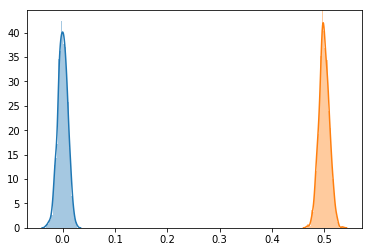

In [45]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)
  

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
weights = initialize_weights((1000,1))
sns.distplot(weights)
# plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")
bias = initialize_bias((1000,1))
sns.distplot(bias)
# plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

class CustomWeightsInitializer:
  def __call__(self, shape):
    return initialize_weights(shape)
  
class CustomBiasInitializer:
  def __call__(self, shape):
    return initialize_bias(shape)



### Define the network architecture for siam net

In [46]:
def get_encoder_model(input_shape):
  model = Sequential()
  model.add(Conv2D(4, (1,48), activation='relu', input_shape=input_shape, 
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-3)))
  model.add(MaxPooling2D(pool_size=(1,16), strides=(1,8)))
  model.add(Conv2D(16, (1,24), activation='tanh', input_shape=input_shape, 
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-3)))
  model.add(MaxPooling2D(pool_size=(1,8), strides=(1,4)))
  model.add(Conv2D(32, (1,12), activation='tanh', input_shape=input_shape, 
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-3)))
  model.add(MaxPooling2D(pool_size=(1,4), strides=(1,2)))
  model.add(Conv2D(64, (4,1), activation='tanh', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-3)))
  model.add(Flatten())
  
  return model

In [47]:
def get_experimental_encoder_model(input_shape):
  model = Sequential()
  model.add(Conv2D(4, (1,48), activation='relu', input_shape=input_shape, 
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-3)))
  model.add(MaxPooling2D(pool_size=(1,16), strides=(1,8)))
  model.add(Conv2D(16, (1,24), activation='tanh', input_shape=input_shape, 
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-3)))
  model.add(MaxPooling2D(pool_size=(1,8), strides=(1,4)))
  model.add(Conv2D(32, (4,1), activation='tanh', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-3)))
  model.add(Flatten())
  
  return model

In [48]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    encoder_model = get_encoder_model(input_shape)
    encoded_l = encoder_model(left_input)
    encoded_r = encoder_model(right_input)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    optimizer = Adam(lr=0.00006)
    siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])
    
    return siamese_net

verify the network

In [49]:
model = get_siamese_model((4, 3800, 1))
model.summary()
model = None







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 3800, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4, 3800, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3072)         16180       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 

# Training Pipeline

In [61]:
data_download(filename='dataset.npy')
def load_dataset():
  dataset = np.load(os.path.join(data_path, 'dataset.npy'))
  return dataset

dataset = load_dataset()

In [51]:
dataset[0:3].T.shape
input_shape = (dataset.shape[1], dataset.shape[2], 1)

In [63]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "dev", "test"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".npy")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                data = np.load(f)
                X = data[:, 1:]
                y = data[:, 0]
                self.data[name] = X
                self.categories[name] = y

    def get_batch(self,batch_size,s="train"):
        
        start = 0
        while True:
            end = min(start+batch_size, self.data[s].shape[0])
            p1, p2 = self.data[s][start:end].T
            yield [dataset[p1][...,np.newaxis], dataset[p2][...,np.newaxis]], self.categories[s][start:end]
            if end == self.data[s].shape[0]:
              start = - batch_size
            start += batch_size
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    
    
    def train(self, model, epochs, batch_size=32):
        train_steps = loader.data['train'].shape[0] // batch_size
        validation_steps = loader.data['dev'].shape[0] // batch_size
        callbacks = [ModelCheckpoint(model_path, monitor='val_acc', 
                                                               save_best_only=True)]
        history = model.fit_generator(self.get_batch(batch_size), 
                                      steps_per_epoch=train_steps, epochs=epochs, 
                                      validation_data=self.get_batch(batch_size, s='dev'),
                                      validation_steps=validation_steps,
                                      callbacks=callbacks)
        return history
      
    def evaluate(self, model, batch_size=32):
        steps = loader.data['test'].shape[0] // batch_size
        history = model.evaluate_generator(self.get_batch(batch_size, s='test'), batch_size)
        return history
        
    
loader = Siamese_Loader(data_path)

loading data from ./data/train.npy
loading data from ./data/dev.npy
loading data from ./data/test.npy


In [ ]:
!git remote set-url origin git@github.com:aninoy/deep-siam.git
!git remote show origin
# !git push origin master

The authenticity of host 'github.com (140.82.114.3)' can't be established.
RSA key fingerprint is SHA256:nThbg6kXUpJWGl7E1IGOCspRomTxdCARLviKw6E5SY8.
RSA key fingerprint is MD5:16:27:ac:a5:76:28:2d:36:63:1b:56:4d:eb:df:a6:48.
Are you sure you want to continue connecting (yes/no)? 

# Evaluation

In [53]:
def save_model(model):
  model.save(model_path)

In [54]:
def plot_history(history):
  import matplotlib.pyplot as plt

  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [55]:
def evaluate(model, batch_size):
  results = loader.evaluate(model, batch_size=batch_size)
  print("Test results")
  print("--------------")
  print(list(zip(model.metrics_names, results)))

In [56]:
def train_and_evaluate(model, batch_size=32, epochs=10):
  print("Starting training process!")
  print("-------------------------------------")
  
  t_start = time.time()
  
  history = loader.train(model, epochs, batch_size)
  
  print("Time for training: {0}".format(time.time()-t_start))
  
  evaluate(model, batch_size)
  
  return history, model

In [57]:
def load_saved_model(refresh=False):
  
  # check if entire model is saved
  if not refresh and os.path.exists(model_path) and os.path.isfile(model_path):
    custom_objects = {
      'initialize_weights': CustomWeightsInitializer,
      'initialize_bias': CustomBiasInitializer
    }
    print("loading saved model architecture and weights/biases")
    model = load_model(model_path, custom_objects=custom_objects)
  else:
    model = get_siamese_model(input_shape)
    if not refresh and os.path.exists(model_weights_path) and os.path.isfile(model_weights_path):
      print("loading saved model weights")
      model.load_weights(model_weights_path)
    
  return model

In [60]:
model = load_saved_model(refresh=True)
history, model = train_and_evaluate(model, batch_size=64, epochs=500)
plot_history(history)

Starting training process!
-------------------------------------
Epoch 1/500


IndexError: index 4001 is out of bounds for axis 0 with size 1001

In [58]:
model = load_saved_model()
evaluate(model, batch_size=64)

IndexError: index 8392 is out of bounds for axis 0 with size 1001